False
<PIL.Image.Image image mode=RGB size=1024x1024 at 0x7F2C9C0816A0>


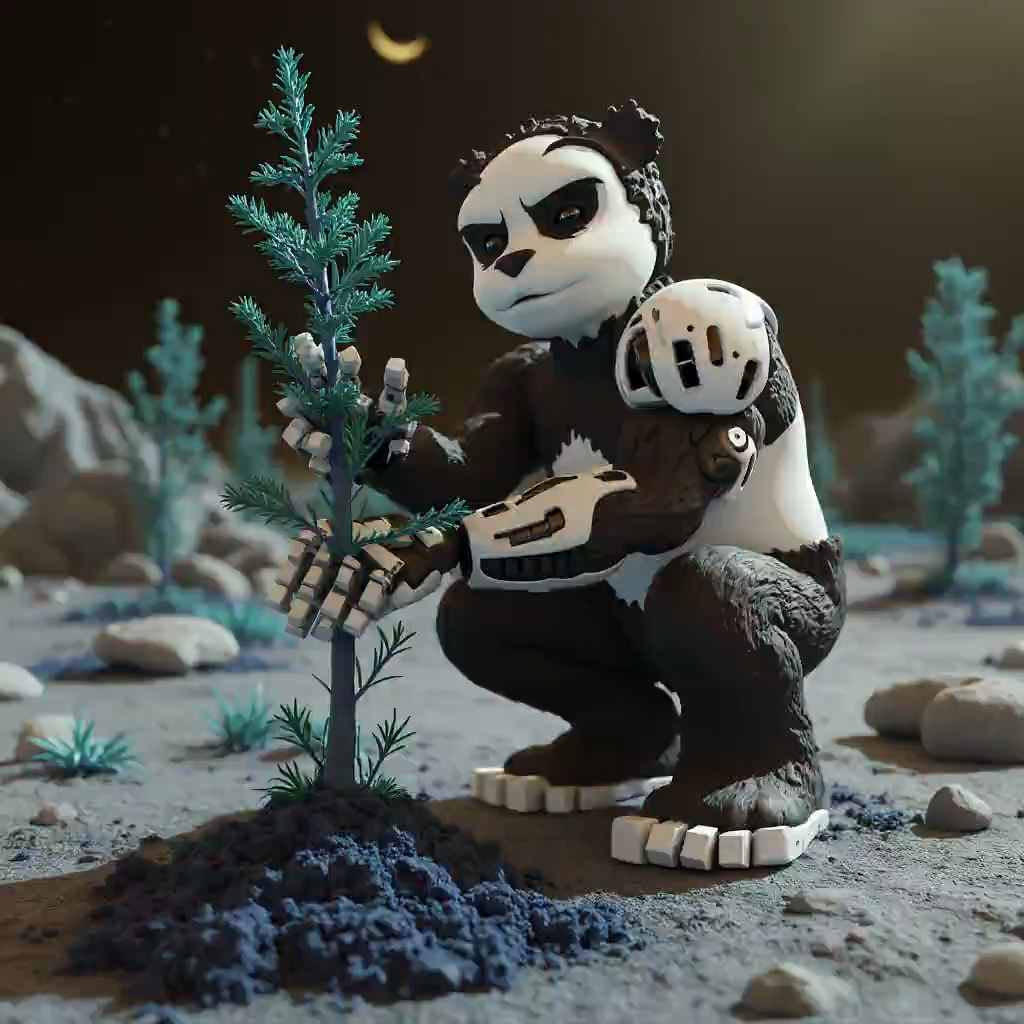

In [37]:
from pathlib import Path
import sys
import time
from typing import Tuple

import requests
import numpy as np
import torch
from PIL import Image, ImageOps
import cv2
import io
from typing import Tuple
import torch
import subprocess
import torchvision.transforms as transforms
import os
import shutil

def ffmpeg_suitability(path):
    try:
        version = subprocess.run([path, "-version"], check=True,
                                 capture_output=True).stdout.decode("utf-8")
    except:
        return 0
    score = 0
    #rough layout of the importance of various features
    simple_criterion = [("libvpx", 20),("264",10), ("265",3),
                        ("svtav1",5),("libopus", 1)]
    for criterion in simple_criterion:
        if version.find(criterion[0]) >= 0:
            score += criterion[1]
    #obtain rough compile year from copyright information
    copyright_index = version.find('2000-2')
    if copyright_index >= 0:
        copyright_year = version[copyright_index+6:copyright_index+9]
        if copyright_year.isnumeric():
            score += int(copyright_year)
    return score


ffmpeg_paths = []
try:
    from imageio_ffmpeg import get_ffmpeg_exe
    imageio_ffmpeg_path = get_ffmpeg_exe()
    ffmpeg_paths.append(imageio_ffmpeg_path)
except:
    if "VHS_USE_IMAGEIO_FFMPEG" in os.environ:
        raise
    # logger.warn("Failed to import imageio_ffmpeg")
if "VHS_USE_IMAGEIO_FFMPEG" in os.environ:
    ffmpeg_path = imageio_ffmpeg_path
else:
    system_ffmpeg = shutil.which("ffmpeg")
    if system_ffmpeg is not None:
        ffmpeg_paths.append(system_ffmpeg)
    if os.path.isfile("ffmpeg"):
        ffmpeg_paths.append(os.path.abspath("ffmpeg"))
    if os.path.isfile("ffmpeg.exe"):
        ffmpeg_paths.append(os.path.abspath("ffmpeg.exe"))
    if len(ffmpeg_paths) == 0:
        # logger.error("No valid ffmpeg found.")
        ffmpeg_path = None
    elif len(ffmpeg_paths) == 1:
        #Evaluation of suitability isn't required, can take sole option
        #to reduce startup time
        ffmpeg_path = ffmpeg_paths[0]
    else:
        ffmpeg_path = max(ffmpeg_paths, key=ffmpeg_suitability)
        
def tensor_to_int(tensor, bits):
    tensor = tensor.cpu().numpy() * (2**bits-1)
    return np.clip(tensor, 0, (2**bits-1))

def tensor_to_bytes(tensor):
    return tensor_to_int(tensor, 8).astype(np.uint8)


def ffmpeg_process(args, file_path, env):
    res = None
    frame_data = yield
    total_frames_output = 0
    if res != b'':
        with subprocess.Popen(args + [file_path], stderr=subprocess.PIPE,
                              stdin=subprocess.PIPE, env=env) as proc:
            try:
                while frame_data is not None:
                    proc.stdin.write(frame_data)
                    frame_data = yield
                    total_frames_output+=1
                proc.stdin.flush()
                proc.stdin.close()
                res = proc.stderr.read()
            except BrokenPipeError as e:
                res = proc.stderr.read()
                raise Exception("An error occurred in the ffmpeg subprocess:\n" \
                        + res.decode("utf-8"))
    yield total_frames_output
    if len(res) > 0:
        print(res.decode("utf-8"), end="", file=sys.stderr)

def tensor_to_video_and_back(images, desired_crf=30):
    # Get input shape and create temp directory
    temp_dir = "temp_video"
    filename = f"frame_{time.time()}".split('.')[0]
    os.makedirs(temp_dir, exist_ok=True)
    
    # Convert single image to list if necessary
    if len(images.shape) == 3:
        images = [images]

    first_image = images[0]
    images = iter(images)
    
    has_alpha = first_image.shape[-1] == 4
    print(has_alpha)
    dim_alignment = 8
    if (first_image.shape[1] % dim_alignment) or (first_image.shape[0] % dim_alignment):
        #output frames must be padded
        to_pad = (-first_image.shape[1] % dim_alignment,
                    -first_image.shape[0] % dim_alignment)
        padding = (to_pad[0]//2, to_pad[0] - to_pad[0]//2,
                    to_pad[1]//2, to_pad[1] - to_pad[1]//2)
        padfunc = torch.nn.ReplicationPad2d(padding)
        def pad(image):
            image = image.permute((2,0,1))#HWC to CHW
            padded = padfunc(image.to(dtype=torch.float32))
            return padded.permute((1,2,0))
        # pad single image
        first_image = pad(first_image)
        # images = map(pad, images)
        new_dims = (-first_image.shape[1] % dim_alignment + first_image.shape[1],
                    -first_image.shape[0] % dim_alignment + first_image.shape[0])
        dimensions = f"{new_dims[0]}x{new_dims[1]}"
        # logger.warn("Output images were not of valid resolution and have had padding applied")
    else:
        dimensions = f"{first_image.shape[1]}x{first_image.shape[0]}"
    
    first_image_bytes = tensor_to_bytes(first_image).tobytes()

    # images = map(tensor_to_bytes, images)
    if has_alpha:
        i_pix_fmt = 'rgba'
    else:
        i_pix_fmt = 'rgb24'
    
    bitrate = 10
    frame_rate = 25
    
    args = [ffmpeg_path, "-v", "error", "-f", "rawvideo", "-pix_fmt", i_pix_fmt,
                    "-s", dimensions, "-r", str(frame_rate), "-i", "-"]
                    
    args += [
        "-n", "-c:v", "libx264",
        "-pix_fmt", "yuv420p",
        "-crf", str(desired_crf),
        
    ] + ["-b:v", str(bitrate) + "M"]
        
    video_path = str(Path(temp_dir) / f"{filename}.mp4")
    
    env = os.environ.copy()
    output_process = ffmpeg_process(args, video_path, env)
    #Proceed to first yield
    output_process.send(None)
    output_process.send(first_image_bytes)
    try:
        output_process.send(None)  # Signal end of input
        frames_written = next(output_process)  # Get the final yield
    except StopIteration:
        pass
    
    time.sleep(0.5)
    
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not created at {video_path}")
        
    # now load the video
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        raise RuntimeError(f"Failed to open video file: {video_path}")
    
    ret, frame = video.read()
    if not ret:
        raise RuntimeError("Failed to read frame from video")
    
    video.release()
    
    try:
        os.remove(video_path)
    except OSError as e:
        print(f"Warning: Could not remove temporary file {video_path}: {e}")
    # convert the frame to a PIL image for ComfyUI
    frame = Image.fromarray(frame)
    return frame
    
    
def pil2tensor(images: Image.Image | list[Image.Image]) -> torch.Tensor:
    """Converts a PIL Image or a list of PIL Images to a tensor."""

    def single_pil2tensor(image: Image.Image) -> torch.Tensor:
        np_image = np.array(image).astype(np.float32) / 255.0
        if np_image.ndim == 2:  # Grayscale
            return torch.from_numpy(np_image).unsqueeze(0)  # (1, H, W)
        else:  # RGB or RGBA
            return torch.from_numpy(np_image).unsqueeze(0)  # (1, H, W, C)

    if isinstance(images, Image.Image):
        return single_pil2tensor(images)
    else:
        return torch.cat([single_pil2tensor(img) for img in images], dim=0)
    
def load(url):
    # get the image from the url
    img = Image.open(requests.get(url, stream=True).raw)
    img = ImageOps.exif_transpose(img)
    return (pil2tensor(img),)

# preview an image
(img, ) = load("https://media.memedeck.xyz/memes/user:08bdc8ed_6015_44f2_9808_7cb54051c666/35c95dfd_b186_4a40_9ef1_ac770f453706.jpeg")

output = tensor_to_video_and_back(img, desired_crf=30)
print(output)
# convert to PIL image
output.show()